In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
%matplotlib inline
print(tf.__version__)

2.2.0


In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [7]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

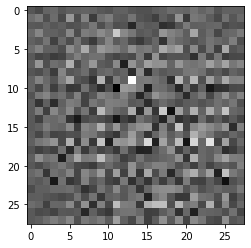

In [8]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00388628]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 101
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
def generate_plot_image(gen_model, test_noise):
    pre_images = gen_model(test_noise, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((pre_images[i, :, :, 0] + 1)/2, cmap='gray')
        plt.axis('off')
    plt.show()

In [16]:
def train_step(input_dim, images):
    noise = tf.random.normal([BATCH_SIZE, input_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_out = discriminator(images, training=True)
    
        gen_image = generator(noise, training=True)
        fake_out = discriminator(gen_image, training=True)
        
        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))

In [17]:
def train(input_dim, dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(input_dim, image_batch)
        if(epoch % 10 == 0):
            print(epoch)
            generate_plot_image(generator, seed)

0


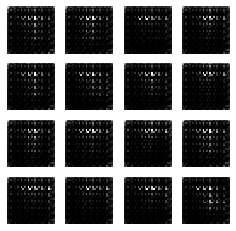

10


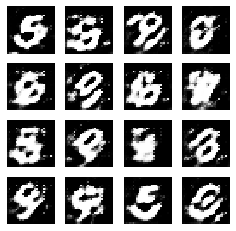

20


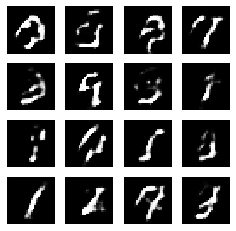

30


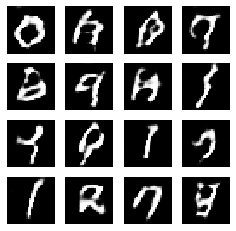

40


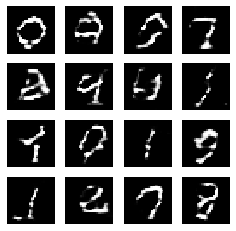

50


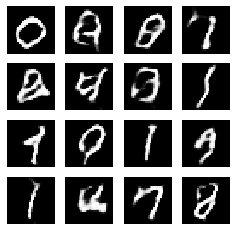

60


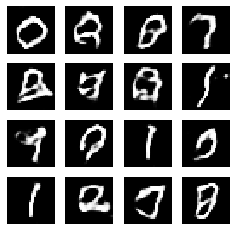

70


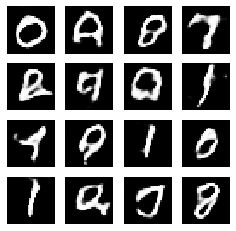

80


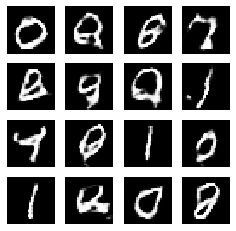

90


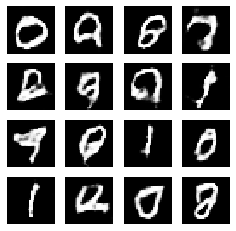

100


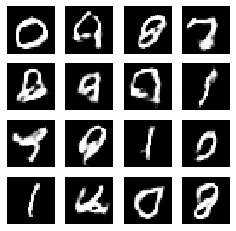

In [18]:
train(100, train_dataset, EPOCHS)